## Raw Data Visualizations

In [1]:
#Importing necessary modules for data management

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import missingno as mo
from scipy.interpolate import interp1d
from scipy.stats import shapiro
from OUTLIERS import smirnov_grubbs as grubbs

In [2]:
#Settings for LaTeX style plots

plt.rcParams.update({
    "font.family": "serif",
    "font.size": 18,
    "axes.titlesize": 18,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.figsize": (8, 6),
    "figure.dpi": 100,
    "savefig.dpi": 200,
    "savefig.format": "png",
    "savefig.transparent": True,
    "axes.grid": True,
    "grid.linewidth": 0.5,
    "grid.linestyle": "--",
    "grid.color": "0.8",
    "image.cmap": "Blues",
    "lines.linewidth": 1.5,
    "lines.markersize": 6,
    "text.usetex": True, "mathtext.fontset": "cm",
    "pgf.preamble": r"\usepackage[utf8]{inputenc}\usepackage[T1]{fontenc}\usepackage{cmbright}"
})

In [3]:
#Importing the raw data
data = pd.read_csv("../data/raw/dataset_mood_smartphone.csv", index_col=0)
data['time'] = pd.to_datetime(data['time'])
data = data.pivot_table(index=['id', 'time'], columns='variable', values='value')
data = data.sort_values(by='time')
data.reset_index(inplace=True)
print(data.describe().to_markdown())

|       | time                          |      activity |   appCat.builtin |   appCat.communication |   appCat.entertainment |   appCat.finance |   appCat.game |   appCat.office |   appCat.other |   appCat.social |   appCat.travel |   appCat.unknown |   appCat.utilities |   appCat.weather |   call |   circumplex.arousal |   circumplex.valence |       mood |        screen |   sms |
|:------|:------------------------------|--------------:|-----------------:|-----------------------:|-----------------------:|-----------------:|--------------:|----------------:|---------------:|----------------:|----------------:|-----------------:|-------------------:|-----------------:|-------:|---------------------:|---------------------:|-----------:|--------------:|------:|
| count | 358926                        | 22965         |       91288      |             74276      |             27125      |         939      |       813     |      5642       |      7650      |      19145      |       2846      |

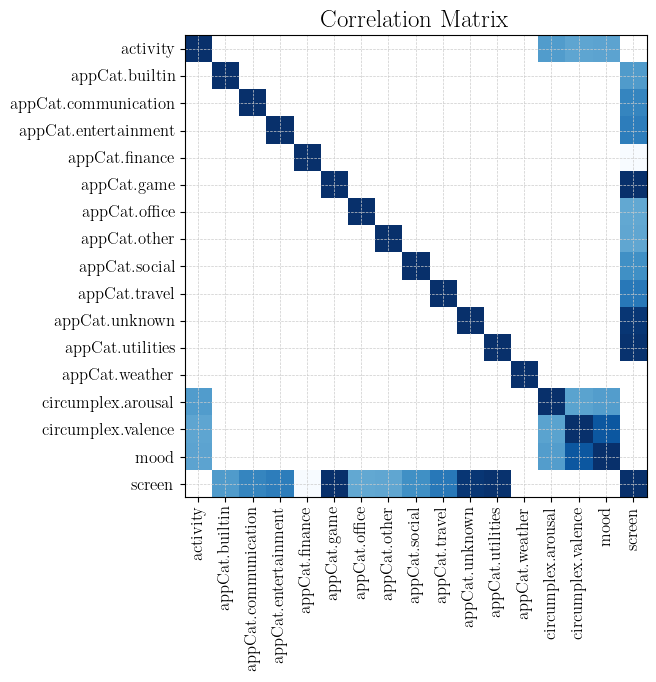

In [4]:
#First Plot: Correlation matrix to identify collinearity - MISSING VALUES

num_grouped = data.select_dtypes(include=[np.number])
# Drop call and sms variables
num_grouped = num_grouped.drop(columns=['call', 'sms'])
corr = num_grouped.corr()
plt.imshow(corr, cmap='Blues', interpolation='nearest')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Matrix")
plt.show()

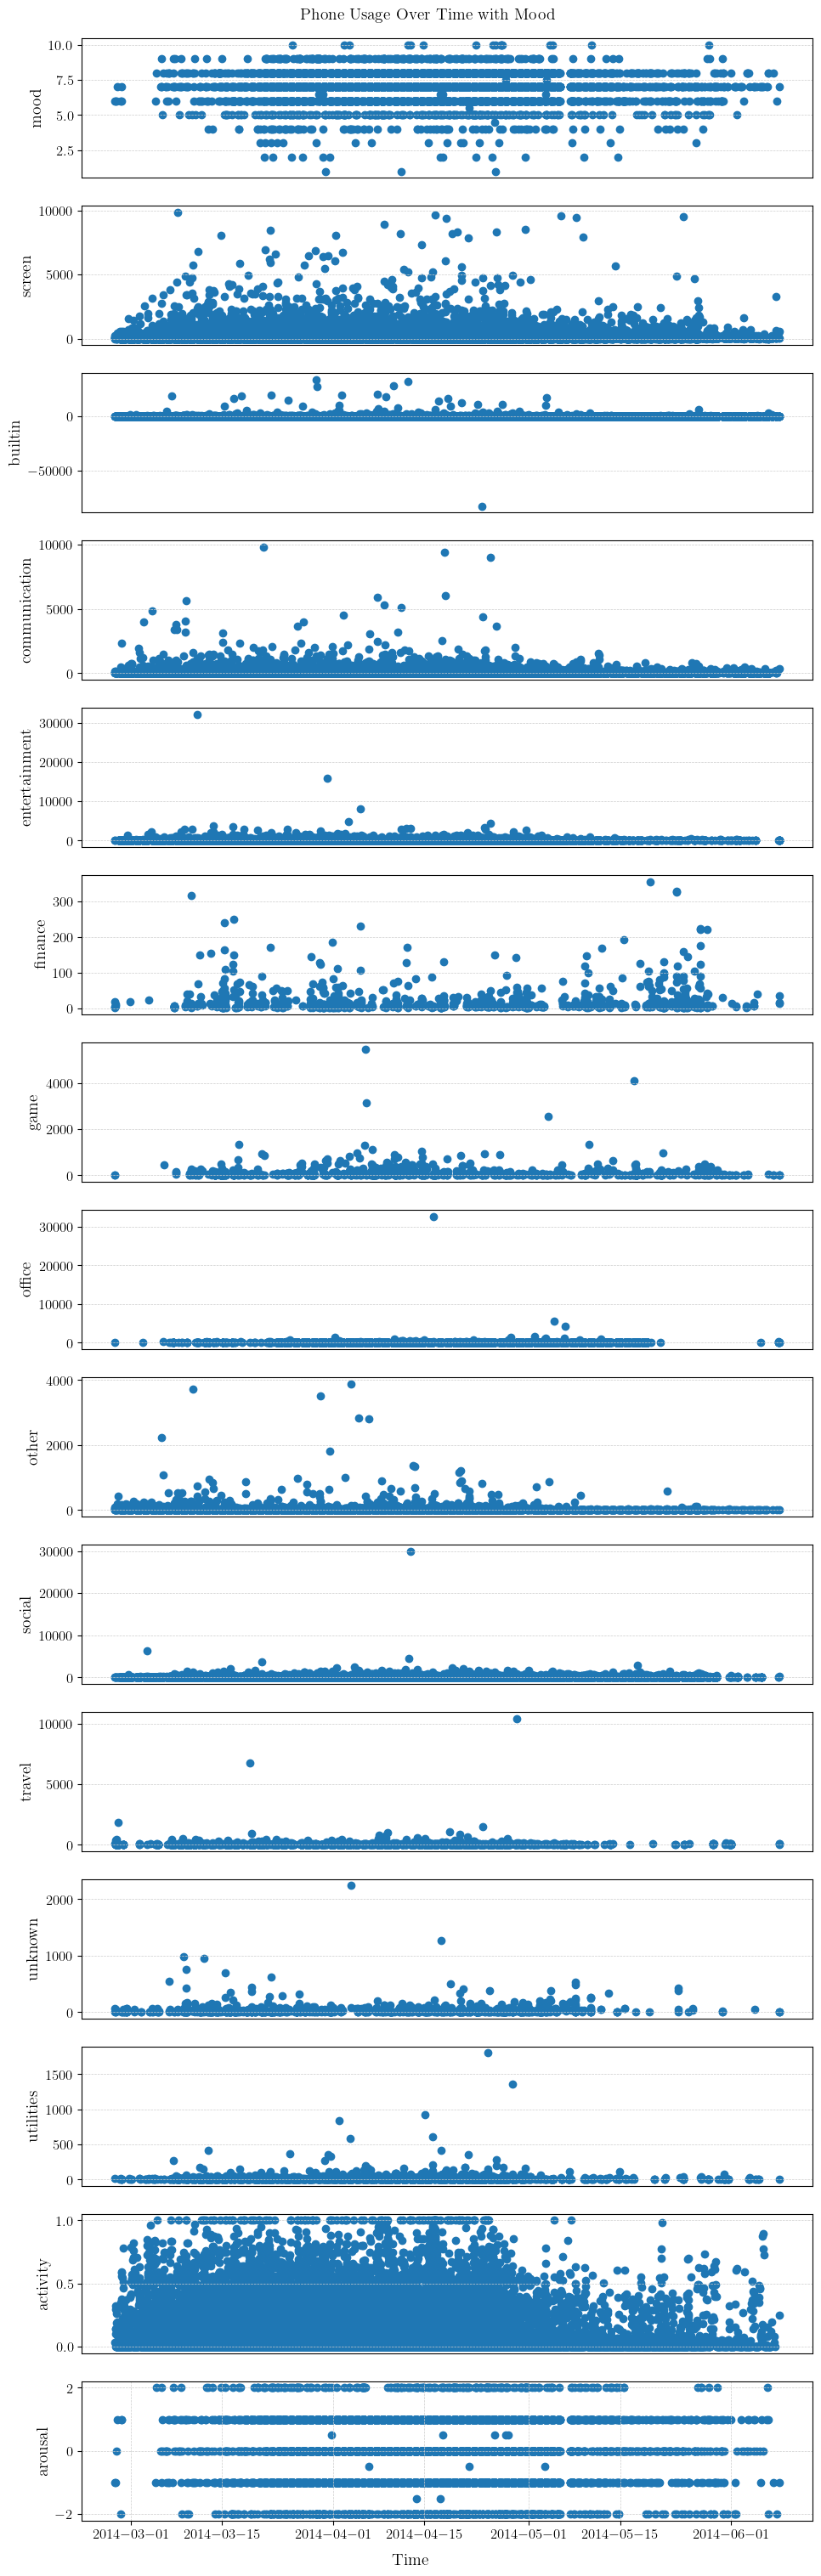

In [5]:
#Second Plot: Stacked plots over time without interpolation

mood = data['mood']
screen = data['screen']
activity = data['activity']
arousal = data['circumplex.arousal']
builtin = data['appCat.builtin']
communication = data['appCat.communication']
entertainment = data['appCat.entertainment']
finance = data['appCat.finance']
game = data['appCat.game']
office = data['appCat.office']
other = data['appCat.other']
social = data['appCat.social']
travel = data['appCat.travel']
unknown = data['appCat.unknown']
utilities = data['appCat.utilities']

fig, axes = plt.subplots(nrows=15, ncols=1, figsize=(10, 30))
axes[0].scatter(data["time"], mood, label='Mood')
axes[1].scatter(data["time"], screen, label='Screen')
axes[2].scatter(data["time"], builtin, label='Built-in')
axes[3].scatter(data["time"], communication, label='Communication')
axes[4].scatter(data["time"], entertainment, label='Entertainment')
axes[5].scatter(data["time"], finance, label='Finance')
axes[6].scatter(data["time"], game, label='Game')
axes[7].scatter(data["time"], office, label='Office')
axes[8].scatter(data["time"], other, label='Other')
axes[9].scatter(data["time"], social, label='Social')
axes[10].scatter(data["time"], travel, label='Travel')
axes[11].scatter(data["time"], unknown, label='Unknown')
axes[12].scatter(data["time"], utilities, label='Utilities')
axes[13].scatter(data["time"], activity, label='Activity')
axes[14].scatter(data["time"], arousal, label='Arousal')

y_labels = ['mood','screen','builtin','communication','entertainment','finance','game',
            'office','other','social','travel','unknown','utilities', 'activity', 'arousal']

#Messing with some of the formatting
for i in range(14):
    axes[i].set_xticklabels([])
    axes[i].set_xticks([])
    axes[i].set_ylabel(y_labels[i])

axes[14].set_ylabel(y_labels[14])
fig.text(0.37, 1, 'Phone Usage Over Time with Mood', va='center', rotation='horizontal', fontsize=14)
fig.text(0.5, 0, 'Time', ha='center', fontsize=14)
plt.tight_layout()
plt.show()

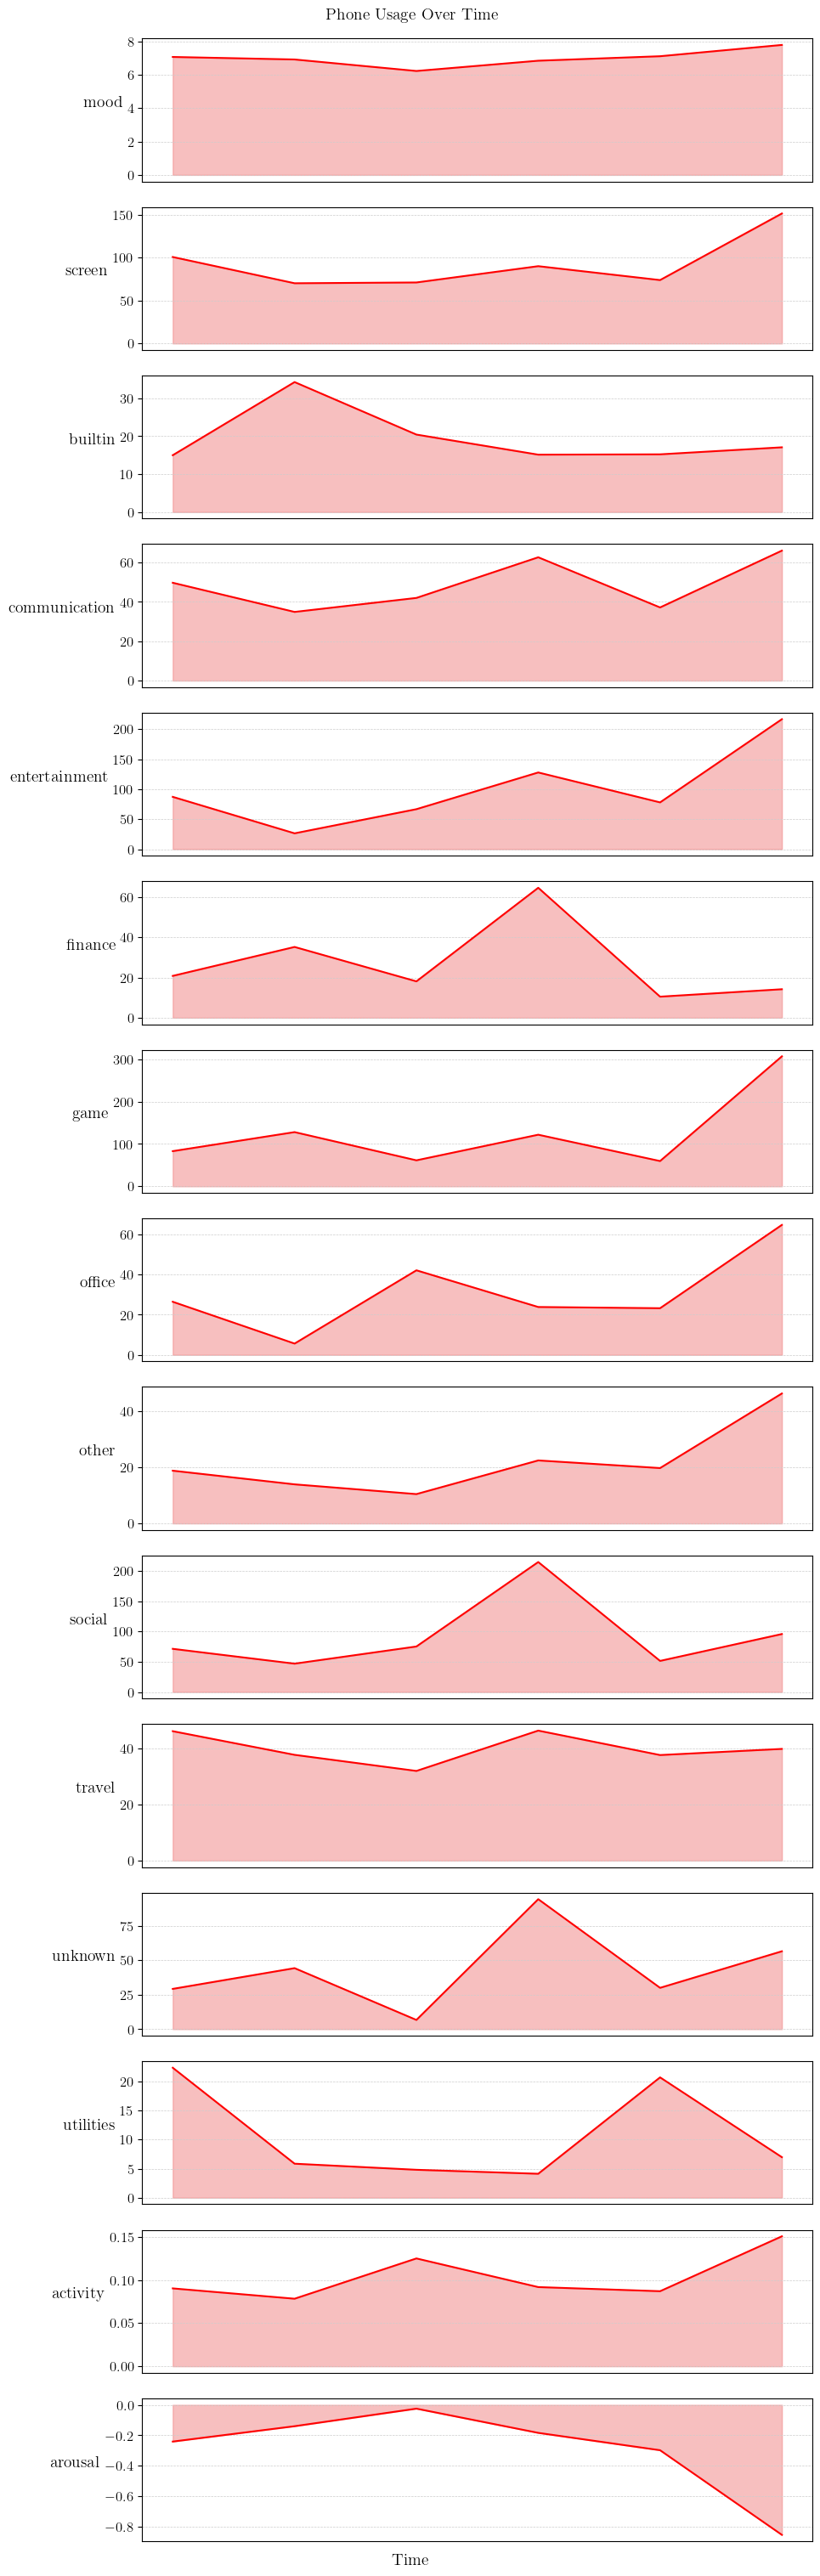

In [6]:
#Trying polynomial regression for trendlines because otherwise the data is kind of choppy

#Have to average over ID, otherwise it won't plot.
mean_data = data.groupby('id').mean()
mean_data = mean_data.dropna()

mood = mean_data['mood']
screen = mean_data['screen']
activity = mean_data['activity']
arousal = mean_data['circumplex.arousal']
builtin = mean_data['appCat.builtin']
communication = mean_data['appCat.communication']
entertainment = mean_data['appCat.entertainment']
finance = mean_data['appCat.finance']
game = mean_data['appCat.game']
office = mean_data['appCat.office']
other = mean_data['appCat.other']
social = mean_data['appCat.social']
travel = mean_data['appCat.travel']
unknown = mean_data['appCat.unknown']
utilities = mean_data['appCat.utilities']

fig, axes = plt.subplots(nrows=15, ncols=1, figsize=(10, 30))

for i, variable_data in enumerate([mood, screen, builtin, communication, entertainment, 
                        finance, game, office, other, social, travel, 
                        unknown, utilities, activity, arousal]):
    x = np.arange(len(mean_data['time']))
    coefficients = np.polyfit(x, variable_data, 5)  
    axes[i].plot(x, np.polyval(coefficients, x), color='red')
    axes[i].fill_between(x, np.polyval(coefficients, x), color='lightcoral', alpha=0.5)

#Messing with labels and formatting
fig.text(0.4, 1, 'Phone Usage Over Time', va='center', rotation='horizontal', fontsize=14)
fig.text(0.5, 0, 'Time', ha='center', fontsize=14)
for ax in axes:
    ax.set_xticklabels([])
    ax.set_xticks([])

for i, ax in enumerate(axes):
    ax.set_ylabel(y_labels[i], rotation=0, ha='right')
    
plt.tight_layout()
plt.show()